# Импорт библиотек


In [1]:
import pandas as pd

from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import phik

import seaborn as sns
import matplotlib.pyplot as plt

import sqlite3

# 1.1 Загрузка данных

Загрузим данные из предоставленных ресурсов.

In [2]:
trips = pd.read_csv('../data/Dataset_с_данными_о_пассажирских_потоках_за_выделенный_период_по.csv', encoding='cp1251', delimiter=';')
stations = pd.read_excel('../data/Dataset_с_параметрами_пропускной_способности_станций.xls')

Дополним данные информацией об станциях из источника (https://www.kaggle.com/datasets/samoilovmikhail/moscow-metro-stations?resource=download) 

In [3]:
metro_stations_extra = pd.read_csv('../data/metro_stations.csv')
metro_stations_extra.head()

,Station_index,English_name,Line,Russian_name,Depth,Line_Neighbors,Transfers,Opened_Date,Lat,Lon,Station_Type
0,1,Bulvar Rokossovskogo,1,Бульвар Рокоссовского,-8.0,2,266,1990-08-01,55.8147,37.7342,column triple-span
1,2,Cherkizovskaya,1,Черкизовская,-9.0,1 3,267,1990-08-01,55.8039,37.7447,single-vault shallow
2,3,Preobrazhenskaya Ploshchad,1,Преображенская площадь,-8.0,2 4,NaN,1965-12-31,55.7964,37.7150,column triple-span
3,4,Sokolniki,1,Сокольники,-9.0,3 5,221,1935-05-15,55.7889,37.6803,single-vault shallow
4,5,Krasnoselskaya,1,Красносельская,-8.0,4 6,NaN,1935-05-15,55.7799,37.6673,column double-span


Объединяем наборы данных

In [4]:
stations_total = stations.merge(metro_stations_extra, left_on='station_name', right_on='Russian_name', how='outer')\
   .dropna(subset=['line_name', 'station_name'])
data = trips.merge(stations_total, left_on='station', right_on='station_name', how='outer')\
                                .drop_duplicates().drop('Line', axis=1)
data.head()

,date,hour,line,station,num_val,line_id,line_name,station_id,station_name,entry_id,...,Station_index,English_name,Russian_name,Depth,Line_Neighbors,Transfers,Opened_Date,Lat,Lon,Station_Type
0,2023-01-01,0.0,КАЛИНИНСКАЯ,Авиамотор-я КалЛ,127.0,14.0,КАЛИНИНСКАЯ,224.0,Авиамотор-я КалЛ,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01,1.0,КАЛИНИНСКАЯ,Авиамотор-я КалЛ,5.0,14.0,КАЛИНИНСКАЯ,224.0,Авиамотор-я КалЛ,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01,5.0,КАЛИНИНСКАЯ,Авиамотор-я КалЛ,18.0,14.0,КАЛИНИНСКАЯ,224.0,Авиамотор-я КалЛ,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-01,6.0,КАЛИНИНСКАЯ,Авиамотор-я КалЛ,160.0,14.0,КАЛИНИНСКАЯ,224.0,Авиамотор-я КалЛ,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-01,7.0,КАЛИНИНСКАЯ,Авиамотор-я КалЛ,338.0,14.0,КАЛИНИНСКАЯ,224.0,Авиамотор-я КалЛ,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Сохраняем данные в базу, попутно обрабатываем возможные ошибки.

In [69]:
try:
    con = sqlite3.connect('../data/db.db')
    data.to_sql('trips', con=con, index=False, if_exists='replace')
except Exception as e:
    print('Ошибка при добавлении данных в базу!')
    print(e)
else:
    print('Успешно!')

Успешно!


# 1.2 Предобработка данных и выделение значимых атрибутов

Для представленного набора данных применим методы кластерного анализа для создания групп, схожих по характеристикам.

In [5]:
# Исключим колонки, где много пропусков
data = data.iloc[:, ((data.isna().sum() / data.shape[0] * 100) <= 30).tolist()]

In [6]:
# Для кластеризации на этапе предобработки данных берем только численные признаки
num_features = data.describe().columns

In [7]:
# Масштабируем данные и исключаем пропуски для корректности кластеризации
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]
)
preprocessor.fit(data[num_features])
X = preprocessor.transform(data[num_features])
# Для кластеризации используем метод KMeans
kmeans = KMeans(n_clusters=3, random_state=1)
cluster = kmeans.fit_predict(X)

In [8]:
X = pd.DataFrame(X, columns=num_features)
X['cluster'] = cluster

С помощью корреляции Пирсона определим наиболее значимые атрибуты, влияющие на образование кластера ('cluster').

Знaчимые атрибуты:  ['output_escalator_count', 'output_doors_count', 'output_turnstile_count', 'hour', 'input_turnstile_total_bandwidth', 'input_turnstile_count', 'num_val', 'input_doors_count', 'entry_id']


<Axes: >

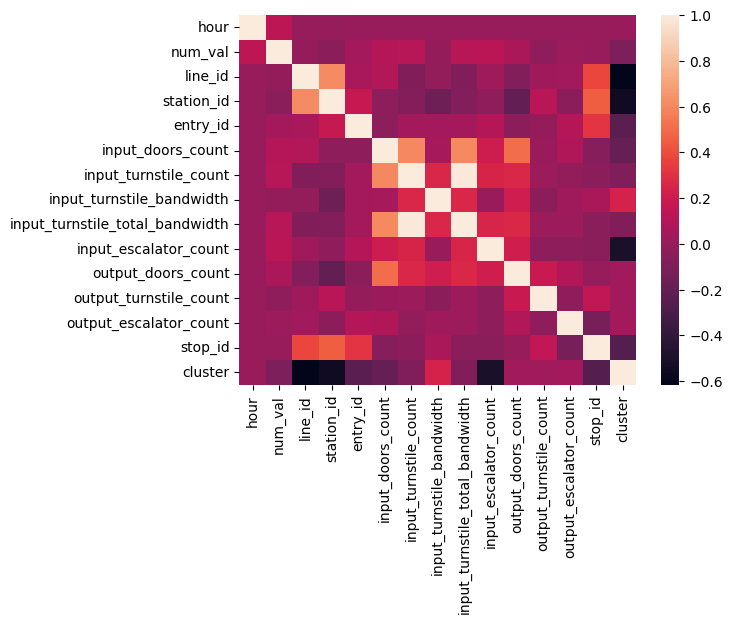

In [9]:
data_corr = X.corr()

selected_columns = data_corr['cluster'].sort_values(ascending=False).iloc[2:11].index.tolist()
print('Знaчимые атрибуты: ', selected_columns)
sns.heatmap(data_corr)

Также добавим атрибуты даты и информации о станции.

In [10]:
selected_columns += ['date', 'line', 'station']

# 1.3 Описание структуры набора данных

Подготовим текстовую расшифровку атрибутов, для анализа плотности распределения используем kde график, а для анализа нормальности распределения используем тест Шапиро-Уилка. Эти методы широко используются для анализа данных, поэтому я их и использую.

In [11]:
col_desc = {
    'output_escalator_count': 'Количество эскалаторов на выход',
    'date': 'Дата',
    'line': 'Ветка',
    'station': 'Станция',
    'output_doors_count': 'Количество дверей на выход',
    'output_turnstile_count': 'Количество турникетов на выход',
    'hour': 'Час',
    'input_turnstile_total_bandwidth': 'Входная пропускная способность турникета',
    'input_turnstile_count': 'Входное количество турникетов',
    'num_val': 'Загруженность станции',
    'input_doors_count': 'Количество дверей на вход',
    'entry_id': 'ID входа',
}

output_escalator_count - Количество эскалаторов на выход
Пустых значений: 815102


KeyboardInterrupt: 

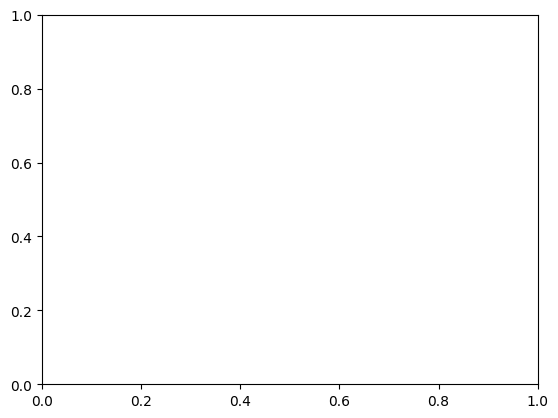

In [12]:
for col in col_desc:
    # Текстовое представление 
    print(f'{col} - {col_desc[col]}')
    # Пустые значения
    print(f'Пустых значений: {data[col].isna().sum()}')

    if col in num_features:
        # Проверка плотности распределения
        data[col].plot.kde()
        plt.title(f'Графический анализ плотности распределения для атрибута {col}')
        plt.show()
    
        # Проверка нормальности
        data[col].hist()
        plt.title(f'Графический анализ нормальности распределения для атрибута {col}')
        plt.show()

        stat, p = shapiro(data[col].fillna(data[col].median()))
        print(f'Статистика: {stat}\nP-value: {p}')
        
        # Вывод о типе рапределения
        if p < 0.05:
            print('Распределение ненормально')
        else:
            print('Распределение нормально')
    
    print('\n\n')

# 1.4 Определение численных характеристик наборов данных

## Общая загруженность станции

In [ ]:
data.groupby('station')['num_val'].sum()

## Пропускная способность в процентах по отношению к средней пропускной способности

In [79]:
# Колонки пропускной способности
max_bandwidth = data.groupby('station')['input_turnstile_total_bandwidth'].max().max()

data.groupby('station')['input_turnstile_total_bandwidth'].max().fillna(0) / max_bandwidth * 100

station
Авиамотор-я КалЛ    31.707317
Авиамоторная         0.000000
Авиамоторная БКЛ     0.000000
Автозавод. МЦК       0.000000
Автозаводская       19.512195
                      ...    
Юго-Восточная        0.000000
Юго-западная        24.390244
Южная               19.512195
Южный речной в-л     0.000000
Ясенево             19.512195
Name: input_turnstile_total_bandwidth, Length: 340, dtype: float64

## Количественные характеристики входного и выходного оборудования

...

## Временные интервалы поездки

...

## Продолжительность поездки

...

# 1.5 Формирование итогового набора данных

In [85]:
data.loc[:, 'station_end'] = data['station'].shift(1)
data = data.dropna(subset='station_end')
data['trip'] = data.apply(lambda row: f'{row['station_end']} - {row['station']}', axis=1)
data.drop_duplicates(subset=('date', 'hour', 'trip'))
data.head()

,date,hour,line,station,num_val,line_id,line_name,station_id,station_name,entry_id,...,Russian_name,Depth,Line_Neighbors,Transfers,Opened_Date,Lat,Lon,Station_Type,station_end,trip
1,2023-01-01,1.0,КАЛИНИНСКАЯ,Авиамотор-я КалЛ,5.0,14.0,КАЛИНИНСКАЯ,224.0,Авиамотор-я КалЛ,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Авиамотор-я КалЛ,Авиамотор-я КалЛ - Авиамотор-я КалЛ
2,2023-01-01,5.0,КАЛИНИНСКАЯ,Авиамотор-я КалЛ,18.0,14.0,КАЛИНИНСКАЯ,224.0,Авиамотор-я КалЛ,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Авиамотор-я КалЛ,Авиамотор-я КалЛ - Авиамотор-я КалЛ
3,2023-01-01,6.0,КАЛИНИНСКАЯ,Авиамотор-я КалЛ,160.0,14.0,КАЛИНИНСКАЯ,224.0,Авиамотор-я КалЛ,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Авиамотор-я КалЛ,Авиамотор-я КалЛ - Авиамотор-я КалЛ
4,2023-01-01,7.0,КАЛИНИНСКАЯ,Авиамотор-я КалЛ,338.0,14.0,КАЛИНИНСКАЯ,224.0,Авиамотор-я КалЛ,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Авиамотор-я КалЛ,Авиамотор-я КалЛ - Авиамотор-я КалЛ
5,2023-01-01,8.0,КАЛИНИНСКАЯ,Авиамотор-я КалЛ,270.0,14.0,КАЛИНИНСКАЯ,224.0,Авиамотор-я КалЛ,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Авиамотор-я КалЛ,Авиамотор-я КалЛ - Авиамотор-я КалЛ


Сохраняем данные в базу данных для дальнейшей обработки.

In [86]:
try:
    con = sqlite3.connect('../data/db.db')
    data.to_sql('metro', con=con, index=False, if_exists='replace')
except Exception as e:
    print('Ошибка при добавлении данных в базу!')
    print(e)
else:
    print('Успешно!')
finally:
    con.close()

Успешно!


# Отчет
В ходе выполнения модуля А было выполнено:
- Загрузка данных из источника, последующая выгрузка данных в sqlite.
- Предобработка данных и выделение значимых атрибутов.
- Описание и анализ структуры набора данных.
- Определение численных характеристик наборов данных.
- Переформирование набора данных.